<a href="https://colab.research.google.com/github/GGpark1/Project/blob/main/Project2_open_university.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 풀고 싶은 문제

- 수업 중 학생의 행동으로 학생의 시험 점수와 수업 F/P 여부를 알 수 있지 않을까?
- 시험 점수와 F/P 여부를 알 수 있다면 학생이 더 나은 퍼포먼스를 보일 수 있도록 유도할 수 있지 않을까?
- 또는 특정 학생이 좋은 퍼포먼스를 보이는 수업을 분석해 그 학생에게 적합한 수업을 추천할 수 있지 않을까?  
- 학생의 이탈률을 낮추고 수료율과 점수를 높일 수 있는 방법을 찾아보자!


2. 목표

- 회귀문제 : 학생의 점수에 영향을 미치는 요인은 무엇인가?

- 분류문제 : 어떤 학생이 낙제할 가능성이 높은가?(F/P)

1. 문제해결 가상 시나리오
- 오픈 유니버시티는 국공립 대학
- 예산을 받기 위해서는 등록생의 수료율을 높여야 함
- 오픈 유니버시티에 다니는 학생들은 대부분은 직업이 있기 때문에 학업에 온전히 집중하기 어려운 상황임 -> 교육에 대해 계속 remind를 해야함
- 교육의 수준을 낮춰서 수료율을 높이면 대학으로서의 위상에 문제가 생김
- 또한 양질의 교육을 원하는 등록생의 니즈를 충족하기 어려워짐
- 현재 교육 수준을 유지하면서 수료율을 높이기 위한 방법은 무엇일까?
- 이 문제를 풀기 위해 대학은 수료율이 낮을 것으로 예상되는 사람들에게 학습 진도율 알림/선수과정 추천 등의 학습 도우미 서비스를 제공하려고 함
- 학습 도우미로 등록생들에게 remind하려는 주기, 기준을 어떻게 설정할 수 있을까?
    - 주기 : 현재 데이터로는 '주기'는 알기 어려움 -> A/B 테스트로 데이터를 구축할 필요가 있음
    - 기준 : 학습 화면 click률, 학습 화면 평균 체류일, late rate

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    
!pip install eli5

from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [ ]:
import pandas as pd

ass = pd.read_csv('/content/drive/MyDrive/education/assessments.csv')
courses = pd.read_csv('/content/drive/MyDrive/education/courses.csv')
results = pd.read_csv('/content/drive/MyDrive/education/studentAssessment.csv')
info = pd.read_csv('/content/drive/MyDrive/education/studentInfo.csv')
reg = pd.read_csv('/content/drive/MyDrive/education/studentRegistration.csv')
vle = pd.read_csv('/content/drive/MyDrive/education/studentVle.csv')
materials = pd.read_csv('/content/drive/MyDrive/education/vle.csv')

In [ ]:
materials.shape

(6364, 6)

In [ ]:
total_merged

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,weighted_score,total_click,total_date
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,82.400000,934.0,20018.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,65.400000,1435.0,37407.0
2,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,76.300000,2158.0,70376.0
3,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,55.000000,1034.0,32361.0
4,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,66.900000,2445.0,84478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22432,GGG,2014J,2620947,-23.0,NaN,269,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,1,80.000000,476.0,23806.0
22433,GGG,2014J,2640965,-4.0,NaN,269,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,0,80.000000,41.0,273.0
22434,GGG,2014J,2645731,-23.0,NaN,269,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,1,77.666667,893.0,33874.0
22435,GGG,2014J,2648187,-129.0,NaN,269,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,1,70.000000,312.0,13930.0


### 1. base line 

#### 1) 최빈값의 비율

accuracy_rate : 68%

In [ ]:
#result에 withdrwan student 정보가 없기 때문에 withdrawn을 그대로 사용하면 merge과정에서 결측값이 withdrawn에 대한 정보를 leakage함
#click, date 등의 data가 없다는 것 자체가 withdrawn 했다는 의미
#결측값을 최빈치로 채워서 쓰면 model의 정확도가 떨어짐

info=info[info["final_result"]!="Withdrawn"]

In [ ]:
#info.loc[(info['final_result'] == 'Withdrawn'), 'final_result'] = 'Fail'
info.loc[(info['final_result'] == 'Distinction'), 'final_result'] = 'Pass'

In [ ]:
#base_line accuracy score : 68%

info['final_result'].value_counts(normalize = True)

Pass    0.685698
Fail    0.314302
Name: final_result, dtype: float64

### 2) without feature engineering - randomforest - base line

accuracy_rate : 64.9%

In [ ]:
info=info[info["final_result"]!="Withdrawn"]
info.loc[info['final_result'] == 'Distinction', 'final_result'] = "Pass"

info.loc[(info['final_result'] == 'Pass'), 'final_result'] = 1
info.loc[(info['final_result'] == 'Fail'), 'final_result'] = 0

In [ ]:
train, test = train_test_split(info, train_size=0.8, random_state=2, stratify=info['code_module'])

In [ ]:
target = 'final_result'
features = train.drop(columns = [target, 'id_student']).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_train = test[target]

In [ ]:
y_train = list(train['final_result'].values)
y_test = list(test['final_result'].values)

Y_train = np.asarray(train['final_result'], dtype = "|S6")
Y_test = np.asarray(test['final_result'], dtype = "|S6") 

In [ ]:
pipe = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(),
                           RandomForestClassifier())

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_pred, y_test)

0.643048128342246

### 2. EDA

#### 1) assessments

In [ ]:
#code_moudule : 수업의 고유 번호
#code_presentation : 수업이 열린 학기(B : 2월 학기 / J : 10월 학기)
#id_assessment : 평가 ID
#data : module 별 최종평가 제출일(ex. 19 -> 수업 시작 후 19일 뒤 최종평가결과 제출)

ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [ ]:
#TMA : tutor 평가
#CMA : computer 평가
#Exam : 시험 평가

ass.assessment_type.value_counts()

TMA     106
CMA      76
Exam     24
Name: assessment_type, dtype: int64

In [ ]:
#module에 따라 TMA/CMA 횟수가 상이함
#Exam은 1번이지만 CCC module은 2번의 Exam이 있음
#학기당 code_module의 weight의 총합은 100임

Ex_count = ass[ass['assessment_type'] == 'Exam']\
.groupby(['code_module', 'code_presentation'])\
.id_assessment.size() 

Tm_count = ass[ass['assessment_type'] == 'TMA']\
.groupby(['code_module', 'code_presentation'])\
.id_assessment.size() 

Cm_count = ass[ass['assessment_type'] == 'CMA']\
.groupby(['code_module', 'code_presentation'])\
.id_assessment.size() 

print(Ex_count)
print(Tm_count)
print(Cm_count)

code_module  code_presentation
AAA          2013J                1
             2014J                1
BBB          2013B                1
             2013J                1
             2014B                1
             2014J                1
CCC          2014B                2
             2014J                2
DDD          2013B                1
             2013J                1
             2014B                1
             2014J                1
EEE          2013J                1
             2014B                1
             2014J                1
FFF          2013B                1
             2013J                1
             2014B                1
             2014J                1
GGG          2013J                1
             2014B                1
             2014J                1
Name: id_assessment, dtype: int64
code_module  code_presentation
AAA          2013J                5
             2014J                5
BBB          2013B                6
    

In [ ]:
#학기당 code_module의 weight의 총합은 평가당 100임(ex. TMA + CMA = 100, Exam = 100 => total weight = 200)
#module CCC는 총합 300, GGG는 100
#weight가 누락된 것인지 / 평가기준이 다른 것인지 확인 필요 -> score에 weight를 가산할 때 특정 수업의 점수가 과대평가될 위험이 있음

ass.groupby(['code_module', 'code_presentation']).weight.sum()

code_module  code_presentation
AAA          2013J                200.0
             2014J                200.0
BBB          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
CCC          2014B                300.0
             2014J                300.0
DDD          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
EEE          2013J                200.0
             2014B                200.0
             2014J                200.0
FFF          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
GGG          2013J                100.0
             2014B                100.0
             2014J                100.0
Name: weight, dtype: float64

In [ ]:
#CCC module에만 CMA에 가중치가 있음 -> 다른 수업에 비해 weight를 100 더 받음 -> 어떤 평가에 가중치를 주는지 확인 필요
#GGG module은 다른 수업에 비해 평가에 가중치를 덜 줌 -> 어떤 평가에 가중치를 주지 않는지 확인 필요

module_C = ass[(ass['assessment_type'] == 'CMA') & (ass['code_module'] == 'CCC')]\
.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.weight.sum()

CMA_weigth = ass.loc[(ass['weight'] != 0) & (ass['assessment_type'] == 'CMA')]

print(module_C)
print(CMA_weigth)

code_module  code_presentation  assessment_type
CCC          2014B              CMA                25.0
             2014J              CMA                25.0
Name: weight, dtype: float64
   code_module code_presentation  id_assessment assessment_type   date  weight
12         BBB             2013B          14991             CMA   54.0     1.0
13         BBB             2013B          14992             CMA   89.0     1.0
14         BBB             2013B          14993             CMA  124.0     1.0
15         BBB             2013B          14994             CMA  159.0     1.0
16         BBB             2013B          14995             CMA  187.0     1.0
24         BBB             2013J          15003             CMA   54.0     1.0
25         BBB             2013J          15004             CMA   96.0     1.0
26         BBB             2013J          15005             CMA  131.0     1.0
27         BBB             2013J          15006             CMA  166.0     1.0
28         BBB       

In [ ]:
#이상치 확인? -> Exam의 가중치가 200

ass[ass['code_module'] == 'CCC']\
.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.weight.sum()

code_module  code_presentation  assessment_type
CCC          2014B              CMA                 25.0
                                Exam               200.0
                                TMA                 75.0
             2014J              CMA                 25.0
                                Exam               200.0
                                TMA                 75.0
Name: weight, dtype: float64

In [ ]:
#CCC module은 다른 module과 달리 시험을 두 번 봄
#다른 module과 비교를 위해서 Exam의 가중치를 50씩 부여할 필요가 있음

ass[ass['assessment_type'] == 'Exam']\
.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.id_assessment.count()

code_module  code_presentation  assessment_type
AAA          2013J              Exam               1
             2014J              Exam               1
BBB          2013B              Exam               1
             2013J              Exam               1
             2014B              Exam               1
             2014J              Exam               1
CCC          2014B              Exam               2
             2014J              Exam               2
DDD          2013B              Exam               1
             2013J              Exam               1
             2014B              Exam               1
             2014J              Exam               1
EEE          2013J              Exam               1
             2014B              Exam               1
             2014J              Exam               1
FFF          2013B              Exam               1
             2013J              Exam               1
             2014B              Exam               

In [ ]:
#GGG module은 CMA와 TMA에 가중치를 주지 않음
#다른 점수와 비교를 위해 CMA와 TMA에 가중치를 줄 필요가 있음

ass[ass['code_module'] == 'GGG']\
.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.weight.sum()

code_module  code_presentation  assessment_type
GGG          2013J              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
             2014B              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
             2014J              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
Name: weight, dtype: float64

In [ ]:
### CCC의 가중치 총합이 200이 되도록 exam의 가중치를 조정

ass.loc[(ass['code_module'] == 'CCC') & (ass['assessment_type'] == 'Exam'), 'weight'] = 50

In [ ]:
ass.loc[(ass['code_module'] == 'CCC') & (ass['assessment_type'] == 'Exam')]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,50.0
63,CCC,2014B,40087,Exam,NaN,50.0
72,CCC,2014J,24299,Exam,NaN,50.0
73,CCC,2014J,40088,Exam,NaN,50.0


In [ ]:
#GGG module의 어떤 type에 어느정도의 가중치를 부여할지 결정해야함 -> 다른 module의 최빈값을 참고해서 결정
#TMA의 최빈값 -> 25.0 -> TMA의 횟수(5회~6회)에 따라 최빈값이 정해짐

ass.loc[ass['assessment_type'] == 'TMA', 'weight']\
.value_counts(ascending = True)

7.5      1
30.0     2
35.0     2
9.0      2
17.5     2
15.0     3
16.0     3
5.0      4
22.0     6
10.0     8
28.0     9
0.0     10
12.5    11
20.0    13
18.0    15
25.0    15
Name: weight, dtype: int64

In [ ]:
#CMA의 최빈값 -> 0 -> 다른 수업에서는 CMA에 가중치를 주지 않음을 확인

ass.loc[ass['assessment_type'] == 'CMA', 'weight']\
.value_counts(ascending = True)

6.0     1
7.0     2
4.0     2
2.0     3
3.0     3
8.0     4
1.0    15
0.0    46
Name: weight, dtype: int64

In [ ]:
ass.loc[(ass['code_module'] == 'GGG') & (ass['assessment_type'] == 'TMA'), 'weight'] = 100/3

In [ ]:
ass.groupby(['code_module', 'code_presentation']).weight.sum()

code_module  code_presentation
AAA          2013J                200.0
             2014J                200.0
BBB          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
CCC          2014B                200.0
             2014J                200.0
DDD          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
EEE          2013J                200.0
             2014B                200.0
             2014J                200.0
FFF          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
GGG          2013J                200.0
             2014B                200.0
             2014J                200.0
Name: weight, dtype: float64

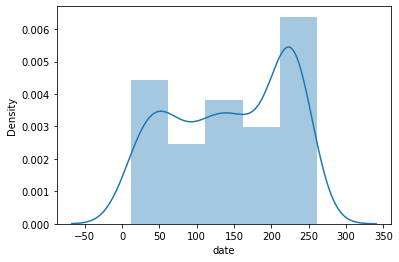

In [ ]:
#date에 이상치 없음 확인

ass['date'].describe()

sns.distplot(ass['date'])

#### 2) Student Assessments

In [ ]:
results.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


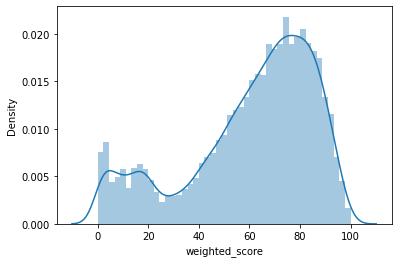

In [ ]:
#score가 한쪽으로 치우쳐있음 -> 가중치를 곱한 뒤 정규화할 필요가 있음

sns.distplot(total_merged['weighted_score'])

In [ ]:
# assessments 정보와 student assessments 정보가 서로 일치하는지 확인
# results에 id_assessment가 일부 누락되어 있음

def compareCols(df1, df2):
    df1Columns = df1.columns.values.tolist()
    df2Columns = df2.columns.values.tolist()

    diffDict = set(df1Columns) & set(df2Columns)

    print('Shared_col : ', diffDict)

    diffList = list(diffDict)

    for col in diffList:
        x = df1[col].isin(df2[col]).value_counts()
        print(x, '\n')

compareCols(ass, results)

Shared_col :  {'id_assessment'}
True     188
False     18
Name: id_assessment, dtype: int64 



In [ ]:
#어떤 id가 누락되었는지 확인

def findDiffValues(df1, df2, col):

    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    diff = set(df1_IDs).difference(set(df2_IDs))
    numberDiff = len(diff)

    print('Missing Value : ', diff)
    print('Missing Value counts : ', numberDiff)

findDiffValues(ass, results, 'id_assessment')

Missing Value :  {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Missing Value counts :  18


In [ ]:
#results table에 Exam 정보가 일부 누락되어 있음 -> CCC 일부와 DDD는 포함되어 있는 걸 보아서 다른 module은 final Exam을 안보는 것일 수도?
#두 table을 'inner'로 merge할 때 아래 정보는 담기지 않음

def printDiffValues(df1, df2, col):
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    diff = set(df1_IDs).difference(set(df2_IDs))

    missingList = list(diff)
    missingDF = df1[df1[col].isin(missingList)]

    return missingDF

printDiffValues(ass, results, 'id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,50.0
73,CCC,2014J,40088,Exam,NaN,50.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0


In [ ]:
#위 결과를 보아 CCC 모듈에서 일부 시험정보가 merge과정에서 누락될 것으로 보이기 때문에 CCC 모듈에 가중치 100을 다시 돌려줌
#merge 후 DDD 모듈을 제외한 

ass.loc[(ass['code_module'] == 'CCC') & (ass['assessment_type'] == 'Exam'), 'weight'] = 100

In [ ]:
results.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

In [ ]:
results.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [ ]:
#미제출(혹은 withdrawn)로 인한 NaN 값으로 target이 유출되기 때문에 0점으로 대체(simpleimputer에서 평균으로 대체될 가능성 있음)

results[results['score'].isnull()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


In [ ]:
ass.loc[ass['id_assessment'] == 34903]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
174,FFF,2014J,34903,TMA,199.0,25.0


In [ ]:
results.fillna(0, inplace=True)

In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173912 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


#### 3) Courses

In [ ]:
#module_presentation_length : 특정학기의 code_module이 realsed되는 기간

courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


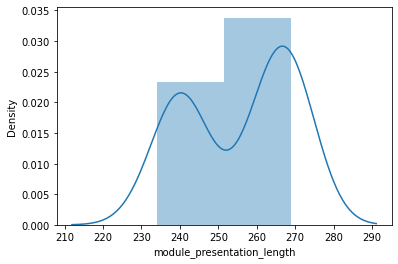

In [ ]:
#이상치 없음 확인

sns.distplot(courses['module_presentation_length'])

In [ ]:
#결측치 없음

courses.isnull().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [ ]:
#중복행 없음

courses[courses.duplicated()]

,code_module,code_presentation,module_presentation_length


#### 4) student registration

In [ ]:
#id_student : 학생 번호
#date_registration : module 등록일(ex. -30은 module 시작 30일 전에 module에 등록했음을 의미함)
#date_unregistration : 모듈 프리젠테이션에서 학생이 등록을 취소한 날짜로 모듈 시작을 기준으로 측정된 일수. 
#과정을 완료한 학생은 이 unregistration columns이 비어 있음. 등록을 취소한 학생은 studentInfo.csv 파일의 final_result 열 값으로 Withdrawal을 가짐 -> **data leakage 주의**

reg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


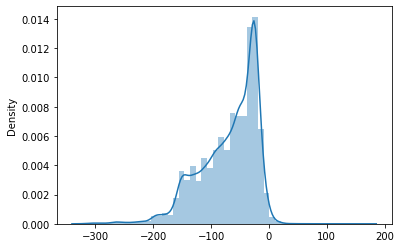

In [ ]:
sns.distplot([reg['date_registration']])

In [ ]:
reg.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [ ]:
reg[reg.duplicated()]

,code_module,code_presentation,id_student,date_registration,date_unregistration


In [ ]:
#등록된 학생 중에 result table에 정보가 없는 학생 확인(결과가 없는 학생)

compareCols(reg, results)

Shared_col :  {'id_student'}
True     26746
False     5847
Name: id_student, dtype: int64 



In [ ]:
#reg에는 학생 정부에 누락이 없음을 확인

compareCols(reg, info)

Shared_col :  {'code_presentation', 'id_student', 'code_module'}
True    32593
Name: code_presentation, dtype: int64 

True     24049
False     8544
Name: id_student, dtype: int64 

True    32593
Name: code_module, dtype: int64 



In [ ]:
#최종 결과가 withdrawn or Fail인 학생이 result에 데이터가 없음
#merge(how=inner)로 할 경우 Fail인 학생의 데이터가 삭제될 수 있음 -> 모두 Pass로 예측됨 -> resul이 포함된 데이터는 left or right로 최종결과가 Fail인 학생도 merge될 수 있도록 해야함
#Pass는 왜 포함되어 있는지 확인 필요

no_resul_stu = printDiffValues(info, results, 'id_student')
no_resul_stu['final_result'].value_counts()

0    1197
1       2
Name: final_result, dtype: int64

In [ ]:
no_resul_stu[no_resul_stu['final_result'] == 'Pass']

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


In [ ]:
reg.loc[reg['id_student'] == 1336190]

,code_module,code_presentation,id_student,date_registration,date_unregistration
645,AAA,2014J,1336190,-23.0,NaN


In [ ]:
#수만개의 데이터 중 2개의 데이터가 오류로 잘못 분류된 것으로 보임
#merge 후 결측치를 처리할 때(즉, results에 데이터가 없는 withdrwan or Fail students를 처리할 때 한번에 처리해도 무방할 것으로 보임)

reg.loc[reg['id_student'] == 1777834]

,code_module,code_presentation,id_student,date_registration,date_unregistration
12893,CCC,2014J,1777834,NaN,NaN


#### 4) Student Vle

In [ ]:
#id_site : 학습이 이루어지는 웹의 id
#activity_type : site의 활동 유형
#Week_from / week_to : site가 relesed되는 기간

materials.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [ ]:
#week_from/to column의 80%이상이 결측치

materials.isnull().sum() * 100 / len(materials)

id_site               0.000000
code_module           0.000000
code_presentation     0.000000
activity_type         0.000000
week_from            82.385292
week_to              82.385292
dtype: float64

In [ ]:
materials[materials.duplicated()]

,id_site,code_module,code_presentation,activity_type,week_from,week_to


#### 6) student vle

In [ ]:
#date : module이 시작된 날짜를 기준으로 측정된 학생이 module 내 material(교보재)와 상호작용을 시작한 일자(ex. -10일이면 module이 presentation되기 10일 전에 교보재를 활용해서 학습을 했다는 뜻(예습))
#sum_click : 학생이 교보재와 상호작용한 횟수

vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


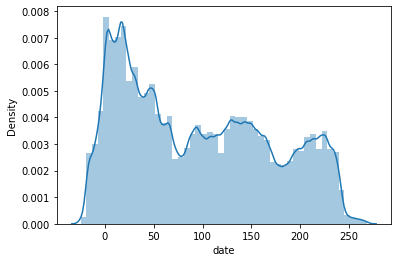

In [ ]:
#-10일이면 module이 presentation되기 10일 전에 교보재를 활용해서 학습을 했다는 뜻(예습)
#숫자가 커지면 커질 수록 학습을 늦게 시작했다는 의미가 될 수 있음

sns.distplot(vle['date'])

In [ ]:
vle.isnull().sum() / len(vle) * 100

code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
date                 0.0
sum_click            0.0
dtype: float64

In [ ]:
#대략 동일한 학생이 4번 이상 vle table에 기록되었음 

vle.nunique() / len(vle) * 100

code_module          0.000066
code_presentation    0.000038
id_student           0.244705
id_site              0.058825
date                 0.002769
sum_click            0.004674
dtype: float64

In [ ]:
#동일한 학생의 모든 활동 결과가 기록되었기 때문에 중복값이 많을 수 밖에 없으며, 다른 활동의 결과이기 때문에 삭제할 수 없음

vle[vle.duplicated()].shape

(787170, 6)

#### 7) Student info

In [ ]:
#region : 지역
#highest_education : 최종 학력
#imd_band : 거주 지역의 빈곤지수(비율이 낮을 수록 빈곤지수가 높음)
#age_band : 연령 범주
#num_of_prev_attempts : 재수강 여부(ex. 1이면 이전에 해당 module을 수강한 적이 있음)
#studied_credits : 생이 현재 공부하고 있는 모듈의 총 학점 수
#disability : 장애여부
#final_result : 해당 module에서의 최종 결과

info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1


###2. Merge & Modeling(before feature engineering)

#### 1) table info

- ass : module 평가 방식에 대한 정보
- courses : module - id_presentation의 length
- results : moduel에 대한 student의 학습 결과
- info : 학생의 정보
- reg : 학생의 등록 정보
- vle : 학생의 module 내 활동 정보
- materials : module의 교보재 정보

#### 2) how to merge

- ass + results = 평가 방식과 평가 결과를 결합하여 평가 결과를 해석
    - inner : result에 exam 정보가 없기 때문에 inner로 결합할 경우 ass table의 일부 결과가 누락됨. 분석에 필요한 자료는 result의 정보이기 떄문에 ass의 정보가 누락되는 건 문제가 되지 않음
    - ass left : ass를 left로 두고 result를 결합하면 id_student에 결측치가 생김. 결합하는 table이 일부 정보가 없더라도 left의 table의 원형은 바뀌지 않기 때문임
    - result left : inner와 같은 결과 
- info + reg + courses = 학생 정보와 학생의 module 등록 정보, module의 정보를 결합(info가 포함된 table이 main table)
    - inner : info와 reg는 'code_presentation', 'code_module', 'id_student'가 같음
    - inner : info와 reg를 결합
- material + vle = module 별 교보재 정보와 교보재 상화작용 table을 결합

### 3) ass + results 

In [ ]:
ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [ ]:
results.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [ ]:
ass_resul = pd.merge(ass, results, how = 'inner', on = 'id_assessment')
ass_resul.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0


### 4) info + reg + courses

In [ ]:
compareCols(info, reg)

Shared_col :  {'code_presentation', 'id_student', 'code_module'}
True    22437
Name: code_presentation, dtype: int64 

True    22437
Name: id_student, dtype: int64 

True    22437
Name: code_module, dtype: int64 



In [ ]:
reg_info = pd.merge(reg, info, how = 'inner', on = ['code_presentation', 'code_module', 'id_student'])
reg_info.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1
2,AAA,2013J,31604,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1
3,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1
4,AAA,2013J,38053,-110.0,NaN,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1


In [ ]:
reg_info_cou = pd.merge(reg_info, courses, how = 'inner', on = ['code_module', 'code_presentation'])
reg_info_cou.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,268
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,268
2,AAA,2013J,31604,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,268
3,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,268
4,AAA,2013J,38053,-110.0,NaN,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,268


In [ ]:
reg_info_cou = reg_info_cou[['code_module', 'code_presentation', 'id_student', 
                        'date_registration', 'date_unregistration', 'module_presentation_length',
                        'gender', 'region', 'highest_education','imd_band',
                        'age_band', 'num_of_prev_attempts', 'studied_credits',
                        'disability', 'final_result']]

reg_info_cou.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1
2,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1
3,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1
4,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1


### 5) material + vle

In [ ]:
materials.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [ ]:
vle.shape

(10655280, 6)

In [ ]:
compareCols(vle, materials)

Shared_col :  {'id_site', 'code_presentation', 'code_module'}
True    10655280
Name: id_site, dtype: int64 

True    10655280
Name: code_presentation, dtype: int64 

True    10655280
Name: code_module, dtype: int64 



In [ ]:
mat_vle = pd.merge(vle, materials, how = 'inner', on = ['id_site', 'code_module', 'code_presentation'])

In [ ]:
mat_vle.shape

(10655280, 9)

### 6) merge all table

#### a. ass_resul + reg_info_cou
- ass_resul table에는 assessment 횟수에 따라 같은 id_student가 있음
- reg_info_cou는 assessment와 상관없이 module 당 등록된 학생의 정보를 담고 있음
- ass_resul table을 module 당 학생에 대한 종합적인 정보로 전환해야 두 table을 merge할 수 있음

In [ ]:
ass_resul.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0


In [ ]:
score = ass_resul

In [ ]:
score['weight*socre']= score['score'] * score['weight']

In [ ]:
score[score['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.nunique()

id_assessment
code_module code_presentation               
CCC         2014B                          1
            2014J                          1
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1

In [ ]:
score_g = score.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(weight_score = ('weight*socre', sum))\
.reset_index()

score_g.shape

(25843, 4)

In [ ]:
total_weight = ass.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight', sum))\
.reset_index()

total_weight.shape

(22, 3)

In [ ]:
total_weighted_score = pd.merge(score_g, total_weight, how = 'inner', on = ['code_module', 'code_presentation'])

In [ ]:
total_weighted_score.head()

#대부분 모듈의 가중치 table에 Exam weight가 포함되어 있으나 Exam score는 없음. Exam weight의 가중치를 빼줌으로서 균형을 맞춤
#CCC 모듈은 시험을 두번보기 때문에 가중치가 300임. 하지만 학기별로 시험 점수가 하나씩 누락되어 있음. 학기별 점수의 weight를 200으로 주어야 함
total_weighted_score['total_weight'] = total_weighted_score['total_weight']-100

#DDD모듈은 Exam score가 있으므로 Exam score의 가중치가 포함된 가중치를 부여함
total_weighted_score.loc[(total_weighted_score.code_module == 'DDD'), 'total_weight'] = 200

In [ ]:
total_weighted_score['weighted_score'] = total_weighted_score['weight_score'] / total_weighted_score['total_weight']
total_weighted_score.drop(columns = ['weight_score', 'total_weight'], inplace=True)

In [ ]:
total_weighted_score

,code_module,code_presentation,id_student,weighted_score
0,AAA,2013J,11391,82.400000
1,AAA,2013J,28400,65.400000
2,AAA,2013J,31604,76.300000
3,AAA,2013J,32885,55.000000
4,AAA,2013J,38053,66.900000
...,...,...,...,...
25838,GGG,2014J,2620947,80.000000
25839,GGG,2014J,2645731,77.666667
25840,GGG,2014J,2648187,70.000000
25841,GGG,2014J,2679821,27.666667


In [ ]:
reg_info_cou.shape

(22437, 15)

In [ ]:
#withdrwan or Fail인 student의 result가 없음
#left로 결합하여 fail인 학생의 정보도 info table에 보존해야함

compareCols(reg_info_cou, total_weighted_score)

Shared_col :  {'code_presentation', 'id_student', 'code_module'}
True    22437
Name: code_presentation, dtype: int64 

True     21238
False     1199
Name: id_student, dtype: int64 

True    22437
Name: code_module, dtype: int64 



In [ ]:
merged = pd.merge(reg_info_cou, total_weighted_score, how = 'left', on = ['id_student', 'code_module', 'code_presentation'])

In [ ]:
merged.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                 6
date_unregistration           22428
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                        875
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
weighted_score                 1287
dtype: int64

### 6) merge all table

#### b. merged + mat_vle
- mat_vle table은 id_site에서의 모든 interaction이 개별로 기록되어 있음
- mat_vle table을 'code_module - code_presentation' 별 student의 interaction을 나타내는 table로 바꿔야함
- merged table의 정보를 보존하기 위해 'inner'가 아니라 'left'를 사용

In [ ]:
merged.head()

NameError: ignored

In [ ]:
mat_vle

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
3,AAA,2013J,28400,546652,-10,8,forumng,NaN,NaN
4,AAA,2013J,30268,546652,-10,3,forumng,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10655275,GGG,2014J,647054,896969,227,8,oucontent,NaN,NaN
10655276,GGG,2014J,499187,896969,228,8,oucontent,NaN,NaN
10655277,GGG,2014J,629258,896969,228,23,oucontent,NaN,NaN
10655278,GGG,2014J,534672,896969,228,1,oucontent,NaN,NaN


In [ ]:
total_click = mat_vle.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ('sum_click', sum))\
.reset_index()

total_click.head()

,code_module,code_presentation,id_student,total_click
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034


In [ ]:
total_date = mat_vle.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_date = ('date', sum))\
.reset_index()

total_date.shape

(29228, 4)

In [ ]:
total_merged = pd.merge(merged, total_click, how = 'left', on = ['code_module', 'code_presentation', 'id_student'])

In [ ]:
total_merged = pd.merge(total_merged, total_date, how = 'left', on = ['code_module', 'code_presentation', 'id_student'])

In [ ]:
total_merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,weighted_score,total_click,total_date
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,82.4,934.0,20018.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,65.4,1435.0,37407.0
2,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,76.3,2158.0,70376.0
3,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,55.0,1034.0,32361.0
4,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,66.9,2445.0,84478.0


<Figure size 720x7200 with 0 Axes>

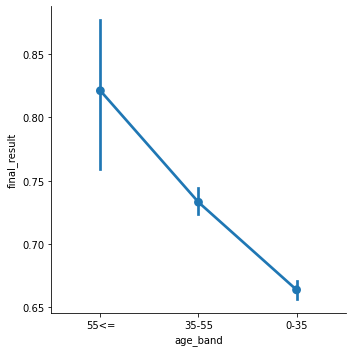

In [ ]:
plt.figure(figsize=(10, 100))
fig = sns.factorplot('age_band', 'final_result', data = total_merged) #size = 4, aspect=2)
#plt.xticks(rotation=70)
plt.show()


In [ ]:
total_merged.loc[(total_merged['final_result'] == 'Pass'), 'final_result'] = 1
total_merged.loc[(total_merged['final_result'] == 'Fail'), 'final_result'] = 0

In [ ]:
total_merged_sim = processor.fit_transform(total_merged)

In [ ]:
total_merged.columns

Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration', 'module_presentation_length', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'weighted_score',
       'total_click', 'total_date'],
      dtype='object')

In [ ]:
total_merged_sim = pd.DataFrame(total_merged_sim, columns = total_merged.columns)

In [ ]:
total_merged_int = total_merged_sim.select_dtypes(exclude=['object'])
total_merged_int.drop(columns=['code_module', 'code_presentation', 'id_student', 'date_unregistration'], inplace = True)

total_merged_int

,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,weighted_score,total_click,total_date
0,-159.0,268.0,1.0,11.0,2.0,5.0,3.0,0.0,240.0,2.0,1.0,82.400000,934.0,20018.0
1,-53.0,268.0,2.0,4.0,2.0,1.0,2.0,0.0,60.0,2.0,1.0,65.400000,1435.0,37407.0
2,-52.0,268.0,2.0,8.0,1.0,9.0,2.0,0.0,60.0,2.0,1.0,76.300000,2158.0,70376.0
3,-176.0,268.0,2.0,9.0,3.0,9.0,1.0,0.0,60.0,2.0,1.0,55.000000,1034.0,32361.0
4,-110.0,268.0,1.0,3.0,1.0,4.0,2.0,0.0,60.0,2.0,1.0,66.900000,2445.0,84478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22432,-23.0,269.0,2.0,4.0,1.0,4.0,1.0,0.0,30.0,1.0,1.0,80.000000,476.0,23806.0
22433,-4.0,269.0,2.0,3.0,3.0,3.0,1.0,0.0,30.0,2.0,0.0,60.926059,41.0,273.0
22434,-23.0,269.0,2.0,11.0,3.0,6.0,2.0,0.0,30.0,2.0,1.0,77.666667,893.0,33874.0
22435,-129.0,269.0,2.0,5.0,1.0,1.0,1.0,0.0,30.0,1.0,1.0,70.000000,312.0,13930.0


In [ ]:
total_merged_int.drop(columns=['age_band', 'highest_education', 'region', 'gender'], inplace = True)

In [ ]:
total_merged_int.drop(columns=['imd_band'], inplace = True)

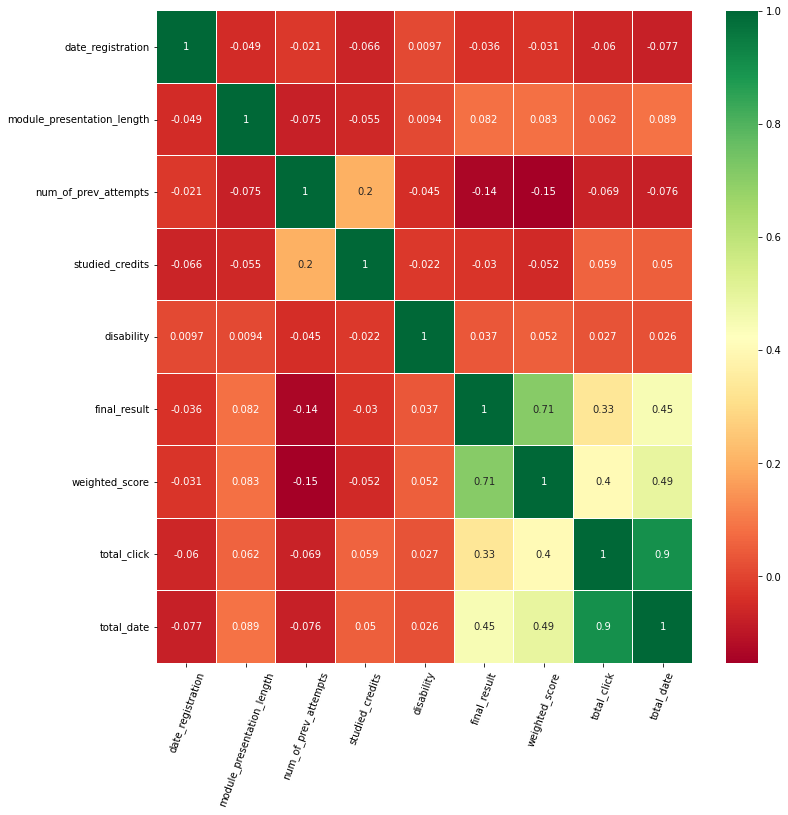

In [ ]:
sns.heatmap(total_merged_int.corr(),annot=True, cmap='RdYlGn',linewidths=0.2, xticklabels = True, yticklabels = True)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.xticks(rotation=70)
plt.show()

In [ ]:
total_merged.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                 6
date_unregistration           22428
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                        875
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
weighted_score                 1287
total_click                     377
total_date                      377
dtype: int64

In [ ]:
total_merged['final_result'].value_counts()

1    15385
0     7052
Name: final_result, dtype: int64

In [ ]:
#nulled = total_merged[total_merged['total_click'].isnull()]

In [ ]:
#nulled['final_result'].value_counts()

In [ ]:
total_merged['total_click'] = total_merged['total_click'].replace(np.nan).fillna(0)
total_merged['weighted_score'] = total_merged['weighted_score'].replace(np.nan).fillna(0)
total_merged['total_date'] = total_merged['total_date'].replace(np.nan).fillna(-18)

total_merged.loc[(total_merged['final_result'] == 'Pass'), 'final_result'] = 1
total_merged.loc[(total_merged['final_result'] == 'Fail'), 'final_result'] = 0

In [ ]:
total_merged.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                 6
date_unregistration           22428
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                        875
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
weighted_score                    0
total_click                       0
total_date                        0
dtype: int64

### 7) modeling

In [ ]:
target = 'final_result'
train, test = train_test_split(total_merged, train_size=0.8, test_size = 0.2, stratify=total_merged['code_module'], random_state=2)

In [ ]:
train, val = train_test_split(train, train_size=0.8, test_size = 0.2, stratify=train['code_module'], random_state=2)

In [ ]:
train.columns

Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration', 'module_presentation_length', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'weighted_score',
       'total_click', 'total_date'],
      dtype='object')

In [ ]:
feature = train.drop(columns = [target, 'id_student', 'date_unregistration','weighted_score', 'total_click']).columns

In [ ]:
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [ ]:
y_train = list(train['final_result'].values)
y_val = list(val['final_result'].values)
y_test = list(test['final_result'].values)

Y_train = np.asarray(train['final_result'], dtype = "|S6")
Y_val = np.asarray(val['final_result'], dtype = "|S6")
Y_test = np.asarray(test['final_result'], dtype = "|S6") 

In [ ]:
X_train.columns

Index(['code_module', 'code_presentation', 'date_registration',
       'module_presentation_length', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability'],
      dtype='object')

In [ ]:
pipe = make_pipeline(OrdinalEncoder(),
                     SimpleImputer(),
                     RandomForestClassifier())

pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['code_module', 'code_presentation',
                                      'gender', 'region', 'highest_education',
                                      'imd_band', 'age_band', 'disability'],
                                mapping=[{'col': 'code_module',
                                          'data_type': dtype('O'),
                                          'mapping': CCC    1
EEE    2
DDD    3
BBB    4
FFF    5
AAA    6
GGG    7
NaN   -2
dtype: int64},
                                         {'col': 'code_presentation',
                                          'data_type': dtype('O'),
                                          'mapping': 2014B    1
2014J    2
2013J    3...
                                          'data_type': dtype('O'),
                                          'mapping': 20-30%      1
NaN         2
10-20       3
80-90%      4
90-100%     5
40-50%      6
60-70%      7
0-10%       8
50-60%

In [ ]:
#별도의 feature engineering을 거치지 않은 model의 정확도 66%
#base_line 정확도 68%

y_pred = pipe.predict(X_val)
accuracy_score(y_pred, y_val)

0.8604456824512535

In [ ]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]

In [ ]:
roc_auc_score(y_val, y_pred_proba)

0.6197991118192093

In [ ]:
#성별/연령/지역/지역빈곤지수/총 학점/장애여부로만 예측했을 때 예측확률은 66%

X_train.head(1)

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
6171,CCC,2014B,-257.0,241,M,London Region,A Level or Equivalent,20-30%,0-35,0,30,Y


In [ ]:
f1_score(y_pred, y_val)

0.7802460069763172

In [ ]:
X_train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
6171,CCC,2014B,-257.0,241,M,London Region,A Level or Equivalent,20-30%,0-35,0,30,Y
14441,EEE,2014J,-8.0,269,M,North Region,HE Qualification,NaN,0-35,0,60,N
10913,DDD,2014B,-36.0,241,F,London Region,Lower Than A Level,10-20,0-35,3,90,N
5153,BBB,2014J,-52.0,262,F,Wales,A Level or Equivalent,10-20,0-35,1,60,N
2353,BBB,2013J,-17.0,268,F,London Region,Lower Than A Level,10-20,35-55,0,60,N


### 1) mat_vle Feature Engineering list

- total_date_per_site : 학생 별 module 상호작용 날짜의 평균
- total_click_per_student : 학생 별 module 상호작용 횟수의 평균

In [ ]:
mat_vle.isnull().sum() / len(mat_vle) * 100

code_module           0.000000
code_presentation     0.000000
id_student            0.000000
id_site               0.000000
date                  0.000000
sum_click             0.000000
activity_type         0.000000
week_from            86.994842
week_to              86.994842
dtype: float64

In [ ]:
mat_vle.drop(columns=['week_from', 'week_to'], inplace=True) #대부분이 결측치인 columns 삭제
mat_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546652,-10,8,forumng
4,AAA,2013J,30268,546652,-10,3,forumng


In [ ]:
#학생별 module 내 교보재와 상호작용 횟수

total_site = mat_vle.groupby(['code_module', 'code_presentation', 'id_student'])\
.id_site\
.count()\
.reset_index()

In [ ]:
total_date_per_site = pd.merge(total_site, total_date, how = 'inner', on = ['code_module', 'code_presentation', 'id_student'])
total_date_per_site.head()

,code_module,code_presentation,id_student,id_site,total_date
0,AAA,2013J,11391,196,20018
1,AAA,2013J,28400,430,37407
2,AAA,2013J,30268,76,179
3,AAA,2013J,31604,663,70376
4,AAA,2013J,32885,352,32361


In [ ]:
total_date_per_site['date_per_site'] = total_date_per_site['total_date'] / total_date_per_site['id_site']
total_date_per_site.drop(columns = ['total_date', 'id_site'], inplace = True)

In [ ]:
total_date_per_site

,code_module,code_presentation,id_student,date_per_site
0,AAA,2013J,11391,102.132653
1,AAA,2013J,28400,86.993023
2,AAA,2013J,30268,2.355263
3,AAA,2013J,31604,106.147813
4,AAA,2013J,32885,91.934659
...,...,...,...,...
29223,GGG,2014J,2640965,14.368421
29224,GGG,2014J,2645731,142.928270
29225,GGG,2014J,2648187,128.981481
29226,GGG,2014J,2679821,36.721311


In [ ]:
total_site.head()

,code_module,code_presentation,id_student,id_site
0,AAA,2013J,11391,196
1,AAA,2013J,28400,430
2,AAA,2013J,30268,76
3,AAA,2013J,31604,663
4,AAA,2013J,32885,352


In [ ]:
total_click_per_student = pd.merge(total_click, total_site, on = ['code_module', 'code_presentation', 'id_student'], how = 'inner')
total_click_per_student.head()

,code_module,code_presentation,id_student,total_click,id_site
0,AAA,2013J,11391,934,196
1,AAA,2013J,28400,1435,430
2,AAA,2013J,30268,281,76
3,AAA,2013J,31604,2158,663
4,AAA,2013J,32885,1034,352


In [ ]:
plt.figure(figsize = (7, 5))
total_click_per_student['click_per_site'] = total_click_per_student['total_click'] / total_click_per_student['id_site']
total_click_per_student.drop(columns = ['total_click', 'id_site'], inplace = True)

<Figure size 504x360 with 0 Axes>

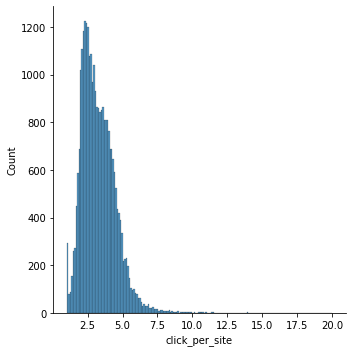

In [ ]:
sns.displot(total_click_per_student['click_per_site'])

<Figure size 504x360 with 0 Axes>

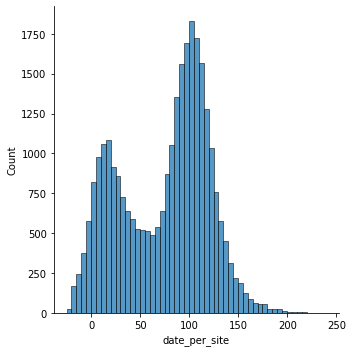

In [ ]:
plt.figure(figsize = (7, 5))
sns.displot(total_date_per_site['date_per_site'])

### 2) ass_resul Feature Engineering list

- score_weights : 가중 점수(regression target)
- fail_rate : Exam, CMA, TMA fail 비율
- late_rate_per_student : 평가물 지각제출 비율
- assessments : merged feature engineering 

In [ ]:
ass_resul.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,weight*socre
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,780.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0,700.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0,720.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0,690.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0,790.0


In [ ]:
ass_resul = ass_resul[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked', 'score']]

In [ ]:
scores = ass_resul

scores['weighted_score'] = scores['weight']*scores['score']
scores.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weighted_score
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,780.0
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,700.0
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,720.0
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,690.0
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,790.0


In [ ]:
sum_scores = scores\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(weighted_score = ('weighted_score', sum))\
.reset_index()

sum_scores.head()

,id_student,code_module,code_presentation,weighted_score
0,6516,AAA,2014J,6350.0
1,8462,DDD,2013J,3490.0
2,8462,DDD,2014J,4300.0
3,11391,AAA,2013J,8240.0
4,23629,BBB,2013B,1669.0


In [ ]:
ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [ ]:
total_weight = ass\
.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight', sum))\
.reset_index()

total_weight.head()

,code_module,code_presentation,total_weight
0,AAA,2013J,200.0
1,AAA,2014J,200.0
2,BBB,2013B,200.0
3,BBB,2013J,200.0
4,BBB,2014B,200.0


In [ ]:
total_weight.loc[total_weight['total_weight'] == 300]

,code_module,code_presentation,total_weight
6,CCC,2014B,300.0
7,CCC,2014J,300.0


In [ ]:
scores[scores['assessment_type'] == 'Exam']

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weighted_score
52923,558914,CCC,2014B,24290,Exam,NaN,230,100.0,0,32.0,3200.0
52924,559706,CCC,2014B,24290,Exam,NaN,234,100.0,0,78.0,7800.0
52925,559770,CCC,2014B,24290,Exam,NaN,230,100.0,0,54.0,5400.0
52926,560114,CCC,2014B,24290,Exam,NaN,230,100.0,0,64.0,6400.0
52927,560311,CCC,2014B,24290,Exam,NaN,234,100.0,0,100.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...
95980,652680,DDD,2014J,25368,Exam,NaN,243,100.0,0,91.0,9100.0
95981,652732,DDD,2014J,25368,Exam,NaN,249,100.0,0,47.0,4700.0
95982,652965,DDD,2014J,25368,Exam,NaN,242,100.0,0,87.0,8700.0
95983,653051,DDD,2014J,25368,Exam,NaN,242,100.0,0,27.0,2700.0


In [ ]:
scores[scores['assessment_type'] == 'Exam'][['code_module','code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.nunique()

id_assessment
code_module code_presentation               
CCC         2014B                          1
            2014J                          1
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1

In [ ]:
sum_scores.head()

,id_student,code_module,code_presentation,weighted_score
0,6516,AAA,2014J,6350.0
1,8462,DDD,2013J,3490.0
2,8462,DDD,2014J,4300.0
3,11391,AAA,2013J,8240.0
4,23629,BBB,2013B,1669.0


In [ ]:
total_weight.head()

,code_module,code_presentation,total_weight
0,AAA,2013J,200.0
1,AAA,2014J,200.0
2,BBB,2013B,200.0
3,BBB,2013J,200.0
4,BBB,2014B,200.0


In [ ]:
total_weight['total_weight'] = total_weight['total_weight']-100
total_weight.loc[(total_weight.code_module == 'DDD'), 'total_weight'] = 200

In [ ]:
score_weights = pd.merge(sum_scores, total_weight,
                         how = 'inner',
                         on = ['code_module', 'code_presentation'])

score_weights.head()

,id_student,code_module,code_presentation,weighted_score,total_weight
0,6516,AAA,2014J,6350.0,100.0
1,24734,AAA,2014J,4750.0,100.0
2,26192,AAA,2014J,8630.0,100.0
3,28061,AAA,2014J,7740.0,100.0
4,31600,AAA,2014J,5550.0,100.0


In [ ]:
score_weights['weighted_score_mean'] = score_weights['weighted_score'] / score_weights['total_weight']
score_weights.drop(columns = ['weighted_score', 'total_weight'], inplace = True)

In [ ]:
score_weights.head()

,id_student,code_module,code_presentation,weighted_score_mean
0,6516,AAA,2014J,63.5
1,24734,AAA,2014J,47.5
2,26192,AAA,2014J,86.3
3,28061,AAA,2014J,77.4
4,31600,AAA,2014J,55.5


In [ ]:
lateSubmission = ass_resul.assign(submission_days = 
                                  ass_resul['date_submitted'] - ass_resul['date'])

In [ ]:
lateSubmission = lateSubmission.assign(late_submission = 
                                       lateSubmission['submission_days'] > 0)

lateSubmission.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weighted_score,submission_days,late_submission
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,780.0,-1.0,False
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,700.0,3.0,True
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,720.0,-2.0,False
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,690.0,7.0,True
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,790.0,0.0,False


In [ ]:
total_late_per_student = lateSubmission\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_late_submission = ('late_submission', sum))\
.reset_index()

total_late_per_student.head()

,id_student,code_module,code_presentation,total_late_submission
0,6516,AAA,2014J,0
1,8462,DDD,2013J,1
2,8462,DDD,2014J,0
3,11391,AAA,2013J,0
4,23629,BBB,2013B,3


In [ ]:
total_count_assessments = lateSubmission[['id_student', 'code_module', 'code_presentation', 'id_assessment']]\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.size()\
.reset_index(name = 'total_assessment')

total_count_assessments.head()

,id_student,code_module,code_presentation,total_assessment
0,6516,AAA,2014J,5
1,8462,DDD,2013J,3
2,8462,DDD,2014J,4
3,11391,AAA,2013J,5
4,23629,BBB,2013B,4


In [ ]:
late_rate_per_student = pd.merge(total_late_per_student,
                                 total_count_assessments,
                                 on = ['id_student',
                                       'code_module',
                                       'code_presentation'],
                                 how = 'inner')

late_rate_per_student['late_rate'] = late_rate_per_student['total_late_submission'] / late_rate_per_student['total_assessment']
late_rate_per_student.drop(columns = ['total_late_submission', 'total_assessment'], inplace = True)

late_rate_per_student.head()

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.000000
1,8462,DDD,2013J,0.333333
2,8462,DDD,2014J,0.000000
3,11391,AAA,2013J,0.000000
4,23629,BBB,2013B,0.750000


<Figure size 504x360 with 0 Axes>

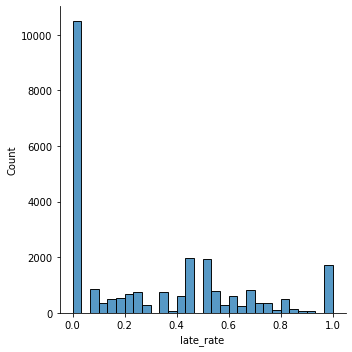

In [ ]:
plt.figure(figsize = (7, 5))
sns.displot(late_rate_per_student['late_rate'])

In [ ]:
passRate = ass_resul
passRate = passRate.assign(fail = passRate['score'] < 40)
passRate['fail'].value_counts()

False    166161
True       7751
Name: fail, dtype: int64

In [ ]:
total_fails_per_students = passRate\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_fails = ('fail', sum))\
.reset_index()

total_fails_per_students.head()

,id_student,code_module,code_presentation,total_fails
0,6516,AAA,2014J,0
1,8462,DDD,2013J,0
2,8462,DDD,2014J,0
3,11391,AAA,2013J,0
4,23629,BBB,2013B,0


In [ ]:
#누수가 일어났던 이유 유추 -> passRate를 그대로 studentInfo 데이터에 붙였음 -> passRate는 'id_assessment'에 따라 같은 'id_sutdent'가 반복됨 
# -> merge 'inner', on = [id_student, code_module, code_pre~] 로 붙이면 [id, ~, ~]가 같지만 [id_assessment]는 다른 row가 info에 가서 붙게 됨 -> python이 on에 부여된 인자로만 row를 판단하기 때문에
# -> 같은 정보를 가진 row가 무수히 많이 생김 -> model의 정확도가 비정상적으로 올라감(왜냐면 같은 데이터만 계속 학습하니까..)
#info가 포함된 merge table은 module 별 assessments가 합산된 정보임 

fail_rate_per_student = pd.merge(total_fails_per_students,
                                 total_count_assessments,
                                 on = ['id_student', 'code_module', 'code_presentation'],
                                 how = 'inner')

fail_rate_per_student.head()

,id_student,code_module,code_presentation,total_fails,total_assessment
0,6516,AAA,2014J,0,5
1,8462,DDD,2013J,0,3
2,8462,DDD,2014J,0,4
3,11391,AAA,2013J,0,5
4,23629,BBB,2013B,0,4


In [ ]:
fail_rate_per_student['fail_rate'] = fail_rate_per_student['total_fails'] / fail_rate_per_student['total_assessment']
fail_rate_per_student.drop(columns = ['total_fails', 'total_assessment'], inplace = True)

In [ ]:
assessments = pd.merge(score_weights,
                       late_rate_per_student,
                       on = ['id_student', 'code_module', 'code_presentation'],
                       how = 'inner')

assessments = pd.merge(assessments,
                       fail_rate_per_student,
                       on = ['id_student', 'code_module', 'code_presentation'],
                       how = 'inner')

In [ ]:
assessments.head()

,id_student,code_module,code_presentation,weighted_score_mean,late_rate,fail_rate
0,6516,AAA,2014J,63.5,0.0,0.0
1,24734,AAA,2014J,47.5,0.8,0.2
2,26192,AAA,2014J,86.3,0.0,0.0
3,28061,AAA,2014J,77.4,0.2,0.0
4,31600,AAA,2014J,55.5,0.6,0.0


### 4. re-merge all talbe

- ass + results = 평가 방식과 평가 결과를 결합하여 평가 결과를 해석
    - inner : result에 exam 정보가 없기 때문에 inner로 결합할 경우 ass table의 일부 결과가 누락됨. 분석에 필요한 자료는 result의 정보이기 떄문에 ass의 정보가 누락되는 건 문제가 되지 않음
    - ass left : ass를 left로 두고 result를 결합하면 id_student에 결측치가 생김. 결합하는 table이 일부 정보가 없더라도 left의 table의 원형은 바뀌지 않기 때문임
    - result left : inner와 같은 결과 
- info + reg + courses = 학생 정보와 학생의 module 등록 정보, module의 정보를 결합(info가 포함된 table이 main table)
    - inner : info와 reg는 'code_presentation', 'code_module', 'id_student'가 같음
    - inner : info와 reg를 결합
- material + vle = module 별 교보재 정보와 교보재 상화작용 table을 결합

In [ ]:
merged = pd.merge(reg_info_cou,
                  total_click_per_student,
                  on=['id_student', 'code_module', 'code_presentation'],
                  how='left')

merged = pd.merge(merged,
                  total_date_per_site,
                  on=['id_student', 'code_module', 'code_presentation'],
                  how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_per_site,date_per_site
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,4.765306,102.132653
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,3.337209,86.993023
2,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,3.254902,106.147813
3,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,2.937500,91.934659
4,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,3.381743,116.843707


In [ ]:
merged = pd.merge(merged,
                  assessments,
                  on=['id_student', 'code_module', 'code_presentation'],
                  how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_per_site,date_per_site,weighted_score_mean,late_rate,fail_rate
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,4.765306,102.132653,82.4,0.0,0.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,3.337209,86.993023,65.4,0.4,0.0
2,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,3.254902,106.147813,76.3,0.0,0.0
3,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,2.937500,91.934659,55.0,1.0,0.4
4,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,3.381743,116.843707,66.9,0.2,0.0


In [ ]:
merged.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                 6
date_unregistration           22428
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                        875
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
click_per_site                  377
date_per_site                   377
weighted_score_mean            1287
late_rate                      1287
fail_rate                      1287
dtype: int64

In [ ]:
merged['click_per_site'].mode(), merged['date_per_site'].mode(), merged['weighted_score_mean'].mode(), merged['late_rate'].mode(), merged['fail_rate'].mode()

(0    2.0
 dtype: float64, 0    2.0
 dtype: float64, 0    0.0
 dtype: float64, 0    0.0
 dtype: float64, 0    0.0
 dtype: float64)

In [ ]:
merged['total_click'] = merged['click_per_site'].replace(np.nan).fillna(0)
merged['total_click'] = merged['date_per_site'].replace(np.nan).fillna(0)
merged['weighted_score_mean'] = merged['weighted_score_mean'].replace(np.nan).fillna(0)

merged['late_rate'] = merged['late_rate'].replace(np.nan).fillna(1.0)
merged['fail_rate'] = merged['fail_rate'].replace(np.nan).fillna(1.0)

In [ ]:
merged.loc[(merged['final_result'] == 'Distinction'), 'final_result'] = 1
merged.loc[(merged['final_result'] == 'Pass'), 'final_result'] = 1
merged.loc[(merged['final_result'] == 'Fail'), 'final_result'] = 0

In [ ]:
merged['inter_date_per_length'] = merged['date_per_site'] / merged['module_presentation_length']
merged.drop(columns = ['date_per_site', 'module_presentation_length'], inplace = True)

<Figure size 504x360 with 0 Axes>

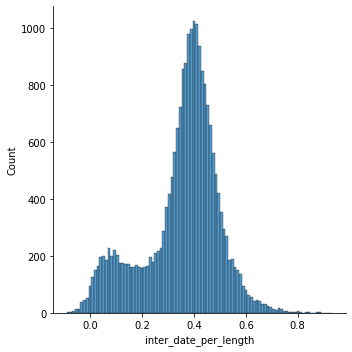

In [ ]:
plt.figure(figsize = (7, 5))
sns.displot(merged['inter_date_per_length'])

In [ ]:
merged.drop(columns = ['total_click'], inplace = True)

### 5. randomforest model

- accuracy_score_test : 0.88
- f1_score_test : 0.91
- roc_auc_score_test : 0.9

In [ ]:
train, test = train_test_split(merged, train_size= 0.8, test_size = 0.2, stratify=merged['code_module'], random_state=2)

In [ ]:
train, val = train_test_split(train, train_size= 0.8, test_size = 0.2, stratify=train['code_module'], random_state=2)

In [ ]:
train.columns

Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability', 'final_result', 'click_per_site', 'weighted_score_mean',
       'late_rate', 'fail_rate', 'inter_date_per_length'],
      dtype='object')

In [ ]:
target = 'final_result'
feature = train.drop(columns = ['final_result','id_student', 'date_unregistration', 'weighted_score_mean', 'fail_rate']).columns

In [ ]:
X_train = train[feature]
y_train = train[[target]]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [ ]:
y_train = list(train['final_result'].values)
y_val = list(val['final_result'].values)
y_test = list(test['final_result'].values)

Y_train = np.asarray(train['final_result'], dtype = "|S6")
Y_val = np.asarray(val['final_result'], dtype = "|S6")
Y_test = np.asarray(test['final_result'], dtype = "|S6") 

In [ ]:
pipe = make_pipeline(OrdinalEncoder(),
                     SimpleImputer(),
                     RandomForestClassifier())

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['code_module', 'code_presentation',
                                      'gender', 'region', 'highest_education',
                                      'imd_band', 'age_band', 'disability'],
                                mapping=[{'col': 'code_module',
                                          'data_type': dtype('O'),
                                          'mapping': CCC    1
EEE    2
DDD    3
BBB    4
FFF    5
AAA    6
GGG    7
NaN   -2
dtype: int64},
                                         {'col': 'code_presentation',
                                          'data_type': dtype('O'),
                                          'mapping': 2014B    1
2014J    2
2013J    3...
                                          'data_type': dtype('O'),
                                          'mapping': 20-30%      1
NaN         2
10-20       3
80-90%      4
90-100%     5
40-50%      6
60-70%      7
0-10%       8
50-60%

In [ ]:
y_pred = pipe.predict(X_val)
print('accuracy_score_val :', round(accuracy_score(y_pred, y_val), 2))
print('f1_score_val :', round(f1_score(y_val, y_pred), 2))

X_val_enco = pipe.named_steps['ordinalencoder'].transform(X_val)
X_val_sim = pipe.named_steps['simpleimputer'].transform(X_val_enco)

y_pred_proba = pipe.named_steps['randomforestclassifier'].predict_proba(X_val_sim)[:, 1]
print('roc_auc_score_val :', round(roc_auc_score(y_val, y_pred_proba), 2))

accuracy_score_val : 0.88
f1_score_val : 0.92
roc_auc_score_val : 0.91


In [ ]:
y_pred = pipe.predict(X_test)
print('accuracy_score_test :', round(accuracy_score(y_pred, y_test), 2))
print('f1_score_test :', round(f1_score(y_test, y_pred), 2))

X_test_enco = pipe.named_steps['ordinalencoder'].transform(X_test)
X_test_sim = pipe.named_steps['simpleimputer'].transform(X_test_enco)

y_pred_proba = pipe.named_steps['randomforestclassifier'].predict_proba(X_test_sim)[:, 1]
print('roc_auc_score_test :', round(roc_auc_score(y_test, y_pred_proba), 2))

accuracy_score_test : 0.87
f1_score_test : 0.91
roc_auc_score_test : 0.91


#### 1) 하이퍼파라미터 최적화

- accuracy_score_test(adjusted) : 0.88
- f1_score_test(adjusted) : 0.91
- roc_auc_score_test(adjusted) : 0.91

In [ ]:
from scipy.stats import randint, uniform

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state = 2)
)

dists = {'randomforestclassifier__n_estimators': randint(20, 300), 
         'randomforestclassifier__max_depth': randint(1, 15), 
         'randomforestclassifier__class_weight': ['balanced', None], 
         'randomforestclassifier__min_samples_leaf' : randint(1, 15)}

clf = RandomizedSearchCV(
    pipe,
    param_distributions = dists,
    n_iter = 100,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
    refit = 'accuracy'
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
pipe1 = clf.best_estimator_

In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('accuracy: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 215}
accuracy:  0.8825820022089937


In [ ]:
y_pred = pipe1.predict(X_val)
print('accuracy_score_val(adjusted) :', round(accuracy_score(y_val, y_pred), 2))
print('f1_score_val(adjusted) :', round(f1_score(y_pred, y_val), 2))

y_pred_proba = pipe1.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

print('roc_auc_score_val(adjusted) :', round(roc_auc_score(y_val, y_pred_proba), 2))

accuracy_score_val(adjusted) : 0.88
f1_score_val(adjusted) : 0.92
roc_auc_score_val(adjusted) : 0.91


In [ ]:
y_pred = pipe1.predict(X_test)
print('accuracy_score_test(adjusted) :', round(accuracy_score(y_test, y_pred), 2))
print('f1_score_test(adjusted) :', round(f1_score(y_pred, y_test), 2))

y_pred_proba = pipe1.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

print('roc_auc_score_test(adjusted) :', round(roc_auc_score(y_test, y_pred_proba), 2))

accuracy_score_test(adjusted) : 0.88
f1_score_test(adjusted) : 0.91
roc_auc_score_test(adjusted) : 0.91


### 6. XGBoosting model

- accracy_socre_test : 0.87
- f1_score_test : 0.91
- roc_auc_score_test : 0.91

In [ ]:
from xgboost import XGBClassifier


pipe_XG = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_XG.fit(X_train, y_train);

In [ ]:
y_pred = pipe_XG.predict(X_val)
print('accuracy_score_val :', round(accuracy_score(y_val, y_pred), 2))
print('f1_score_val : ', round(f1_score(y_val, y_pred), 2))

y_pred_proba = pipe_XG.predict_proba(X_val)[:, 1]
print('roc_auc_score_val : ', round(roc_auc_score(y_val, y_pred_proba), 2))

accuracy_score_val : 0.88
f1_score_val :  0.91
roc_auc_score_val :  0.91


In [ ]:
y_pred = pipe_XG.predict(X_test)
print('accracy_socre_test :', round(accuracy_score(y_pred, y_test), 2))
print('f1_score_test :', round(f1_score(y_test, y_pred), 2))

y_pred_proba = pipe_XG.predict_proba(X_test)[:, 1]
print('roc_auc_score_test :', round(roc_auc_score(y_test, y_pred_proba),2))

accracy_socre_test : 0.88
f1_score_test : 0.91
roc_auc_score_test : 0.9


### 7. XGBoosting model 하이퍼파라미터 조정
- accuracy_score_test : 0.88
- f1_score_test : 0.92
- roc_auc_score_test : 0.91

In [ ]:
encoder = OrdinalEncoder()
X_train_enco = encoder.fit_transform(X_train)

imputer = SimpleImputer()
X_train_pre = imputer.fit_transform(X_train_enco)

In [ ]:
encoder = OrdinalEncoder()
X_train_enco = encoder.fit(X_train)

dists = {
 'max_depth': randint(1, 10),
 'min_child_weight':randint(0, 6),
 'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
 'n_estimator' : randint(100, 200),
 'scale_pos_weight' : [1, 1.5, 2]
}

gsearch1 = RandomizedSearchCV(estimator = XGBClassifier(seed=27), 
                              param_distributions = dists,
                              scoring='roc_auc',
                              n_jobs=-1,
                              n_iter = 100,
                              cv=5)

gsearch1.fit(X_train_pre, y_train)

RandomizedSearchCV(cv=5, estimator=XGBClassifier(seed=27), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7a2bdd3c90>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f79f65acad0>,
                                        'n_estimator': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f79ea4ff790>,
                                        'scale_pos_weight': [1, 1.5, 2]},
                   scoring='roc_auc')

In [ ]:
print('최적 하이퍼파라미터: ', gsearch1.best_params_)
print('roc_auc: ', gsearch1.best_score_)

최적 하이퍼파라미터:  {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 3, 'n_estimator': 132, 'scale_pos_weight': 2}
roc_auc:  0.9150192726641325


In [ ]:
pipe_XG1 = gsearch1.best_estimator_

In [ ]:
X_val_enco = encoder.transform(X_val)
X_val_pre = imputer.transform(X_val_enco)

In [ ]:
y_pred = pipe_XG1.predict(X_val_pre)
print('accuracy_score_val :', round(accuracy_score(y_pred, y_val), 2))
print('f1_score_val :', round(f1_score(y_pred, y_val), 2))

y_pred_proba = pipe_XG1.predict_proba(X_val_pre)[:, 1]
print('roc_auc_score :', round(roc_auc_score(y_val, y_pred_proba),2))

accuracy_score_val : 0.88
f1_score_val : 0.92
roc_auc_score : 0.91


In [ ]:
X_test_enco = encoder.transform(X_test)
X_test_pre = imputer.transform(X_test_enco)

In [ ]:
y_pred = pipe_XG1.predict(X_test_pre)
print('accuracy_score_test :', round(accuracy_score(y_pred, y_test), 2))
print('f1_score_test :', round(f1_score(y_pred, y_test), 2))

y_pred_proba = pipe_XG1.predict_proba(X_test_sim)[:, 1]
print('roc_auc_score_test :', round(roc_auc_score(y_test, y_pred_proba),2))

accuracy_score_test : 0.87
f1_score_test : 0.91
roc_auc_score_test : 0.91


### 8. randomforest regression

- mae_test : 11.92
- r2_score_test : 0.61

In [ ]:
merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_per_site,weighted_score_mean,late_rate,fail_rate,inter_date_per_length
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,4.765306,82.4,0.0,0.0,0.381092
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,3.337209,65.4,0.4,0.0,0.324601
2,AAA,2013J,31604,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,3.254902,76.3,0.0,0.0,0.396074
3,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,2.937500,55.0,1.0,0.4,0.343040
4,AAA,2013J,38053,-110.0,NaN,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,3.381743,66.9,0.2,0.0,0.435984


In [ ]:
target = 'weighted_score_mean'
feature = train.drop(columns = ['final_result','id_student', 'date_unregistration', 'weighted_score_mean', 'fail_rate']).columns

In [ ]:
train, val = train_test_split(merged, train_size = 0.8, random_state=2, stratify=merged['code_module'])
train, test = train_test_split(train, train_size = 0.8, random_state=2, stratify=train['code_module'])

In [ ]:
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [ ]:
y_train

6171     51.1700
14441    93.7600
10913    46.3500
5153     77.1500
2353     82.3800
          ...   
9316     12.7825
16266    61.0000
18686    10.2500
9562     65.9375
1745     75.2900
Name: weighted_score_mean, Length: 14359, dtype: float64

In [ ]:
X_train.head()

,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_per_site,late_rate,inter_date_per_length
6171,CCC,2014B,-257.0,M,London Region,A Level or Equivalent,20-30%,0-35,0,30,Y,3.815271,0.428571,0.467326
14441,EEE,2014J,-8.0,M,North Region,HE Qualification,NaN,0-35,0,60,N,2.588185,0.000000,0.402092
10913,DDD,2014B,-36.0,F,London Region,Lower Than A Level,10-20,0-35,3,90,N,2.369565,0.000000,0.235973
5153,BBB,2014J,-52.0,F,Wales,A Level or Equivalent,10-20,0-35,1,60,N,2.409091,0.400000,0.355066
2353,BBB,2013J,-17.0,F,London Region,Lower Than A Level,10-20,35-55,0,60,N,1.750000,0.454545,0.048507


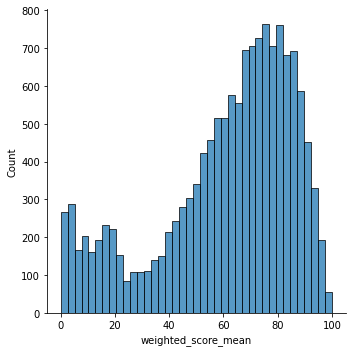

In [ ]:
sns.displot(y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe_reg = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=2))

pipe_reg.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['code_module', 'code_presentation',
                                      'gender', 'region', 'highest_education',
                                      'imd_band', 'age_band', 'disability'],
                                mapping=[{'col': 'code_module',
                                          'data_type': dtype('O'),
                                          'mapping': CCC    1
EEE    2
DDD    3
BBB    4
FFF    5
AAA    6
GGG    7
NaN   -2
dtype: int64},
                                         {'col': 'code_presentation',
                                          'data_type': dtype('O'),
                                          'mapping': 2014B    1
2014J    2
2013J    3...
                                          'mapping': 20-30%      1
NaN         2
10-20       3
80-90%      4
90-100%     5
40-50%      6
60-70%      7
0-10%       8
50-60%      9
30-40%     10
70-80%     11
dtype: int64},
                

In [ ]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

y_pred = pipe_reg.predict(X_val)
print('mae_val :', round(mean_absolute_error(y_val, y_pred), 2))
print('r2_score_val :', round(r2_score(y_val, y_pred), 2))

mae_val : 12.39
r2_score_val : 0.59


In [ ]:
y_pred = pipe_reg.predict(X_test)
print('mae_test :', round(mean_absolute_error(y_test, y_pred), 2))
print('r2_score_test :', round(r2_score(y_test, y_pred), 2))

mae_test : 12.13
r2_score_test : 0.59


In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=2)
)

dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1)
    }

clf_reg = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf_reg.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
pipe_reg1 = clf_reg.best_estimator_

In [ ]:
print('최적 하이퍼파라미터: ', clf_reg.best_params_)
print('MAE: ', -clf_reg.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.6242067446024842, 'randomforestregressor__n_estimators': 482, 'simpleimputer__strategy': 'mean'}
MAE:  11.796752664863611


In [ ]:
y_pred = pipe_reg1.predict(X_val)
print('mae_val :', round(mean_absolute_error(y_val, y_pred), 2))
print('r2_score_val :', round(r2_score(y_val, y_pred), 2))

mae_val : 12.16
r2_score_val : 0.61


In [ ]:
y_pred = pipe_reg1.predict(X_test)
print('mae_test :', round(mean_absolute_error(y_test, y_pred), 2))
print('r2_score_test :', round(r2_score(y_test, y_pred), 2))

mae_test : 11.86
r2_score_test : 0.61


### 9. XGB Regression

In [ ]:
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
imputer = SimpleImputer()
X_train_enco = encoder.fit_transform(X_train)
X_train_sim = imputer.fit_transform(X_train_enco)
X_train_sim = pd.DataFrame(X_train_sim, columns = X_train_enco.columns)

X_val_enco = encoder.transform(X_val)
X_val_sim = imputer.fit_transform(X_val_enco)
X_val_sim = pd.DataFrame(X_val_sim, columns = X_val_enco.columns)

boosting = XGBRegressor(n_estimators=1000,
                        objective='reg:squarederror',
                        learning_rate=0.2,
                        n_jobs=-1)

eval_set = [(X_train_sim, y_train), 
            (X_val_sim, y_val)]

boosting.fit(X_train_sim, y_train, 
             eval_set=eval_set,
             early_stopping_rounds=50)

[0]	validation_0-rmse:53.4378	validation_1-rmse:53.1844
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:44.0697	validation_1-rmse:43.8841
[2]	validation_0-rmse:36.7906	validation_1-rmse:36.6788
[3]	validation_0-rmse:31.2303	validation_1-rmse:31.2025
[4]	validation_0-rmse:27.0581	validation_1-rmse:27.1105
[5]	validation_0-rmse:23.9748	validation_1-rmse:24.12
[6]	validation_0-rmse:21.7209	validation_1-rmse:21.9421
[7]	validation_0-rmse:20.1168	validation_1-rmse:20.4044
[8]	validation_0-rmse:19.0003	validation_1-rmse:19.3649
[9]	validation_0-rmse:18.2164	validation_1-rmse:18.6626
[10]	validation_0-rmse:17.6855	validation_1-rmse:18.1789
[11]	validation_0-rmse:17.2883	validation_1-rmse:17.8294
[12]	validation_0-rmse:16.9986	validation_1-rmse:17.585
[13]	validation_0-rmse:16.7785	validation_1-rmse:17.403
[14]	validation_0-rmse:16.6386	validation_1-rmse:17.2842


XGBRegressor(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror')

In [ ]:
y_pred = boosting.predict(X_val_sim)
mae = mean_absolute_error(y_pred, y_val)
r2 = r2_score(y_pred, y_val)
print('MAE_val_boosting :', round(mae, 2))
print('R2_score_val_boosting :', r2)

MAE_val_boosting : 12.21
R2_score_val_boosting : 0.3434224782911669


In [ ]:
encoder = OrdinalEncoder()
imputer = SimpleImputer()
X_train_enco = encoder.fit_transform(X_train)
X_train_sim = imputer.fit_transform(X_train_enco)
X_train_sim = pd.DataFrame(X_train_sim, columns = X_train_enco.columns)


dists = {
 'max_depth': randint(1, 10),
 'min_child_weight':randint(0, 6),
 'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
 'n_estimator' : randint(200,300),
 'lambda' : [1, 1.25, 1.5, 2, 3]}

boosting1 = RandomizedSearchCV(estimator = XGBRegressor(), 
                              param_distributions = dists,
                              scoring= 'neg_mean_absolute_error',
                              n_jobs=-1,
                              n_iter = 100,
                              cv=5)

boosting1.fit(X_train_sim, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[13:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'lambda': [1, 1.25, 1.5, 2, 3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7a2af66d90>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f79ea49f950>,
                                        'n_estimator': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7a2afcfad0>},
                   scoring='neg_mean_absolute_error')

In [ ]:
print('최적 하이퍼파라미터: ', boosting1.best_params_)
print('MAE: ', -boosting1.best_score_)

최적 하이퍼파라미터:  {'lambda': 1.25, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimator': 231}
MAE:  11.50399738941996


In [ ]:
pipe_XGB = boosting1.best_estimator_

In [ ]:
X_val_enco = encoder.transform(X_val)
X_val_sim = imputer.fit_transform(X_val_enco)
X_val_sim = pd.DataFrame(X_val_sim, columns = X_val_enco.columns)

y_pred = pipe_XGB.predict(X_val_sim)
mae = mean_absolute_error(y_pred, y_val)
print('MAE_val_boosting(adj) :', round(mae, 2))

r2 = r2_score(y_pred, y_val)
print('r2_score_boosting(adj) :', round(r2, 2))

MAE_val_boosting(adj) : 11.83
r2_score_boosting(adj) : 0.4


### 10. model selection

- classification : XGBoosting 하이퍼파라미터 randomsearchCV
    - accuracy_score_test : 0.88
    - f1_score_test : 0.92
    - roc_auc_score_test : 0.91
- regresstion : RandomForest 하이퍼파라미터 randomsearchCV
    - mae_test : 11.91
    - r2_score_test : 0.6

### 11. 시각화

최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 101}

In [ ]:
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 34.0 MB 100.8 MB/s 
     |████████████████████████████████| 13.1 MB 30.4 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=126ae7c81c546dbc7ceb4f2df9e3e5f1cb8f676a2901c8f259f2f4626bd110fc
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 564 kB 5.0 MB/s 


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
import shap

In [ ]:
target = 'final_result'

X = merged.drop(columns=target)
y = merged[target]

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size= 0.8, test_size = 0.2, stratify=X['code_module'], random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size= 0.8, test_size = 0.2, stratify= X_train_val['code_module'], random_state=2)

In [ ]:
len(X_val)

3590

In [ ]:
len(y_val)

3590

In [ ]:
val_id = X_val['id_student']

In [ ]:
X_val_id = X_val

In [ ]:
val_id.shape

(3590,)

In [ ]:
target = 'final_result'
feature = X.drop(columns = ['id_student', 'date_unregistration', 'weighted_score_mean', 'fail_rate', 'weighted_score_mean']).columns

X_train = X_train[feature]
X_val = X_val[feature]
X_test = X_test[feature]

Y_train = np.asarray(y_train, dtype = "|S6")
Y_val = np.asarray(y_val, dtype = "|S6")
Y_test = np.asarray(y_test, dtype = "|S6") 

In [ ]:
X_train.columns

Index(['code_module', 'code_presentation', 'date_registration', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'click_per_site', 'late_rate', 'inter_date_per_length'],
      dtype='object')

In [ ]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

In [ ]:
X_train.head()

,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_per_site,late_rate,inter_date_per_length
6171,CCC,2014B,-257.0,M,London Region,A Level or Equivalent,20-30%,0-35,0,30,Y,3.815271,0.428571,0.467326
14441,EEE,2014J,-8.0,M,North Region,HE Qualification,NaN,0-35,0,60,N,2.588185,0.000000,0.402092
10913,DDD,2014B,-36.0,F,London Region,Lower Than A Level,10-20,0-35,3,90,N,2.369565,0.000000,0.235973
5153,BBB,2014J,-52.0,F,Wales,A Level or Equivalent,10-20,0-35,1,60,N,2.409091,0.400000,0.355066
2353,BBB,2013J,-17.0,F,London Region,Lower Than A Level,10-20,35-55,0,60,N,1.750000,0.454545,0.048507


In [ ]:
processor = make_pipeline(OrdinalEncoder(), 
                          SimpleImputer())

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)


model = RandomForestClassifier(
    n_estimators=100,
    max_depth = 10,
    min_samples_leaf = 10,
    n_jobs=-1,
)

model.fit(X_train_sim, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_jobs=-1)

In [ ]:
encoder

OrdinalEncoder(cols=['code_module', 'code_presentation', 'gender', 'region',
                     'highest_education', 'imd_band', 'age_band',
                     'disability'],
               mapping=[{'col': 'code_module', 'data_type': dtype('O'),
                         'mapping': CCC    1
EEE    2
DDD    3
BBB    4
FFF    5
AAA    6
GGG    7
NaN   -2
dtype: int64},
                        {'col': 'code_presentation', 'data_type': dtype('O'),
                         'mapping': 2014B    1
2014J    2
2013J    3
2013B    4
NaN     -2
dtype: int64},
                        {'col': 'ge...
No Formal quals                4
Post Graduate Qualification    5
NaN                           -2
dtype: int64},
                        {'col': 'imd_band', 'data_type': dtype('O'),
                         'mapping': 20-30%      1
NaN         2
10-20       3
80-90%      4
90-100%     5
40-50%      6
60-70%      7
0-10%       8
50-60%      9
30-40%     10
70-80%     11
dtype: int64},
               

In [ ]:
X_val_df = pd.DataFrame(X_val_processed, columns = X_val.columns)

In [ ]:
X_val.columns

Index(['code_module', 'code_presentation', 'date_registration', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'click_per_site', 'late_rate', 'inter_date_per_length'],
      dtype='object')

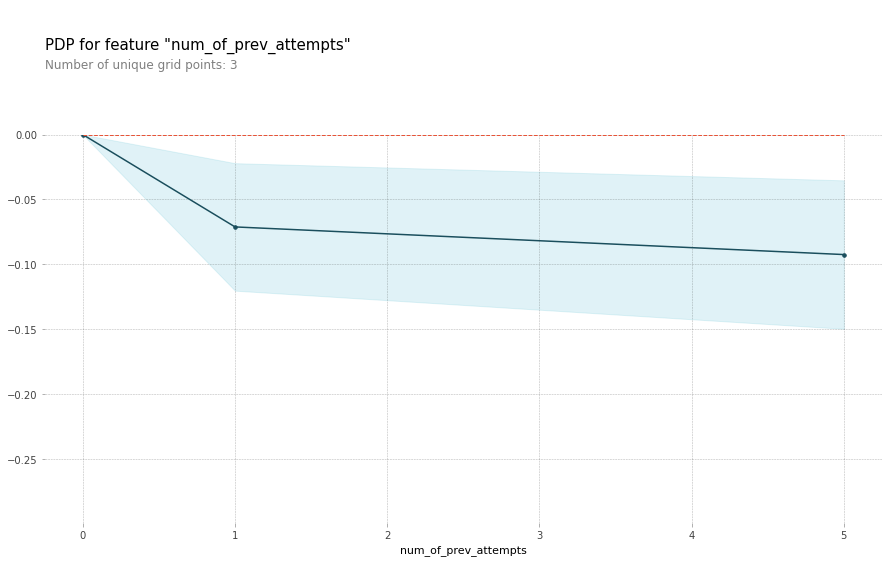

In [ ]:
feature = 'num_of_prev_attempts'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

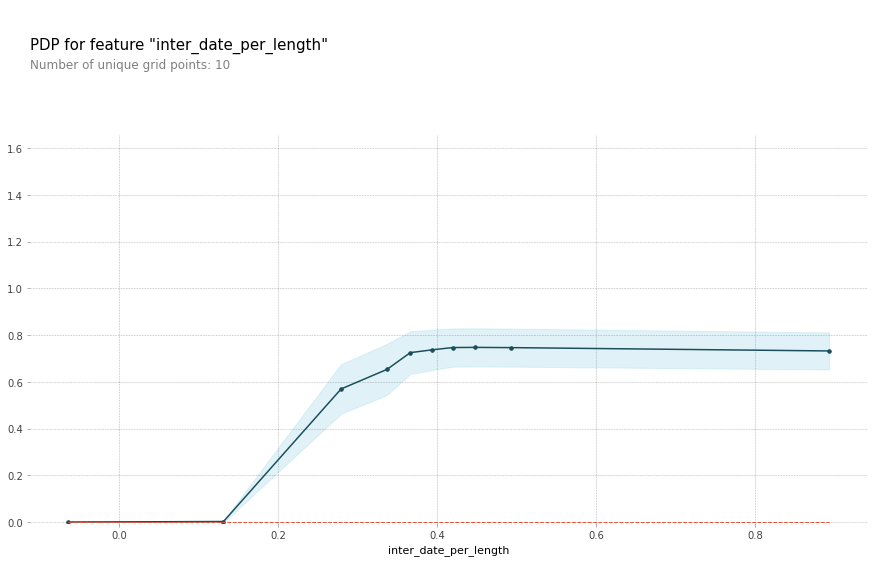

In [ ]:
feature = 'inter_date_per_length'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

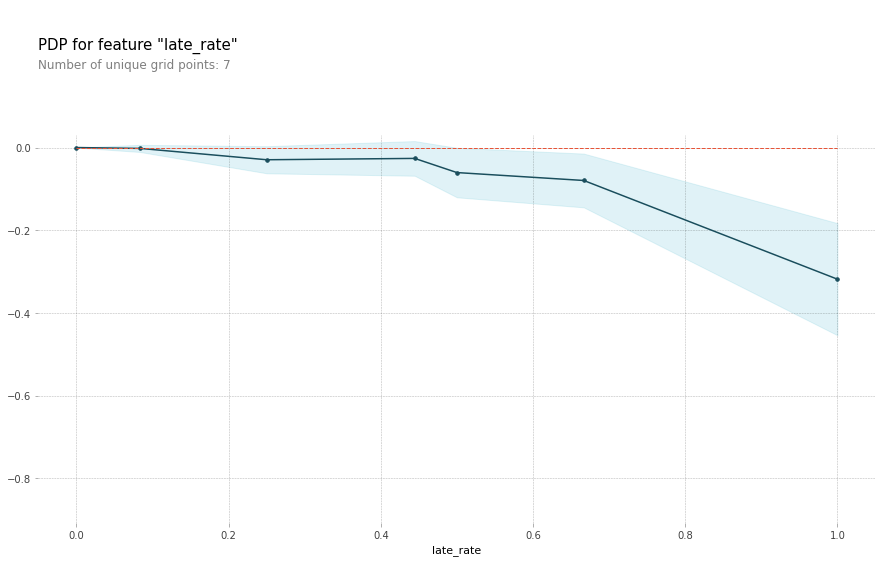

In [ ]:
feature = 'late_rate'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

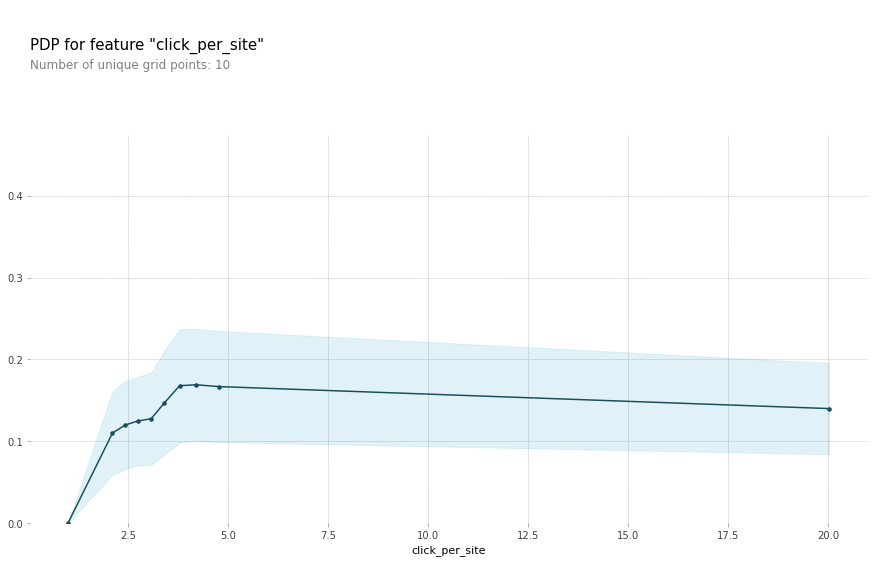

In [ ]:
feature = 'click_per_site'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

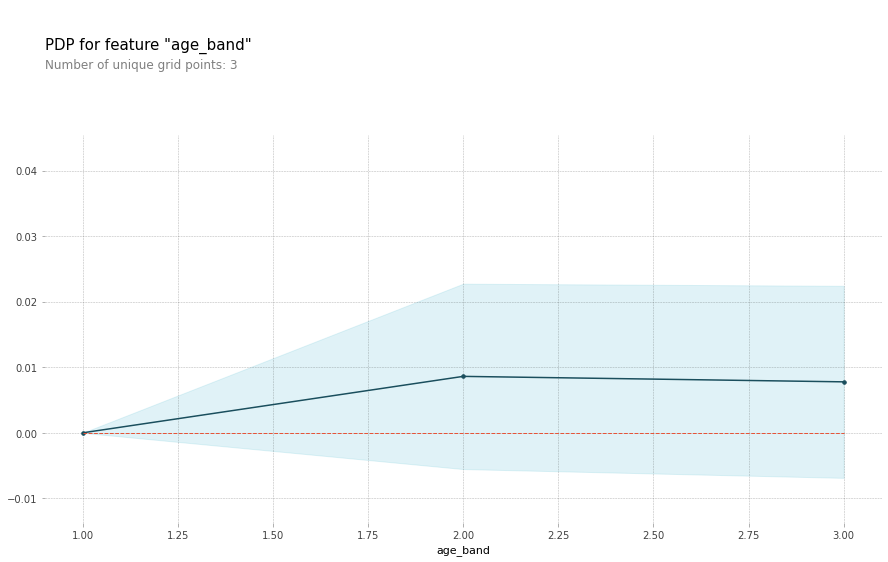

In [ ]:
feature = 'age_band'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

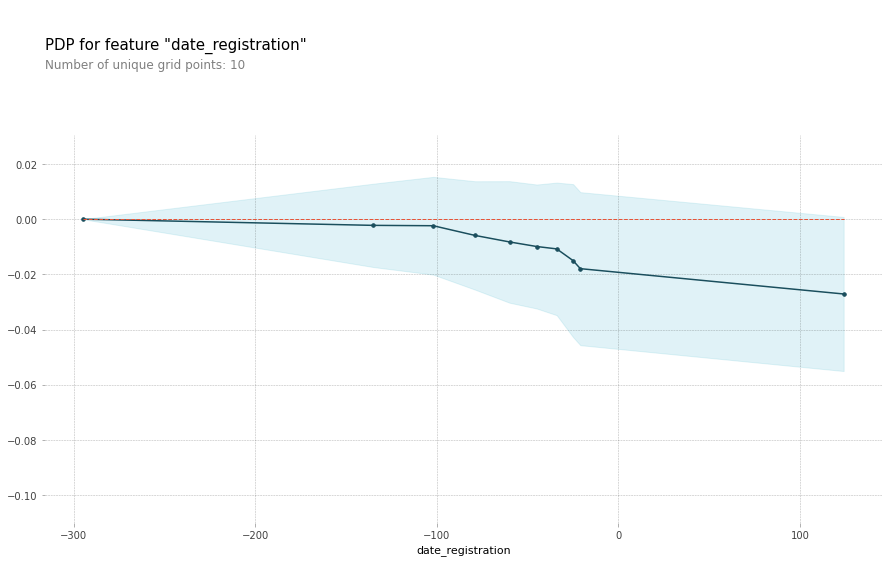

In [ ]:
feature = 'date_registration'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

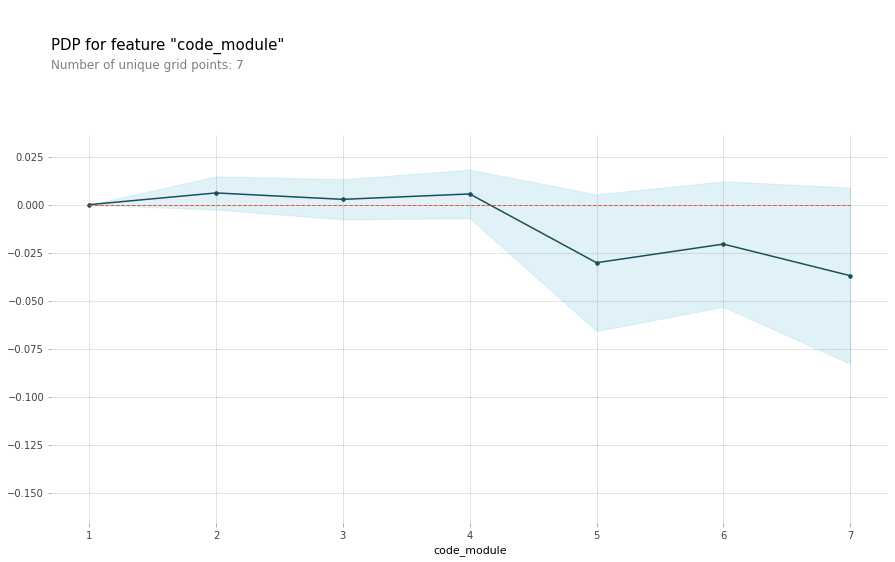

In [ ]:
feature = 'code_module'

isolated = pdp_isolate(model=model, dataset=X_val_df, model_features = X_val_df.columns, feature = feature, grid_type='percentile')
pdp_plot(isolated, feature_name=feature);

In [ ]:
feature = ['inter_date_per_length', 'code_module']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_df,
    model_features=X_val_df.columns, 
    features=feature)

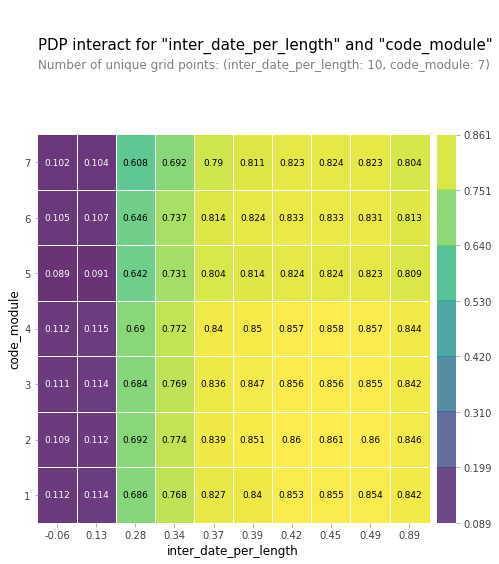

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=feature);

#수업별 inter_date_per_lenghth의 확률 분포를 봤을 때, 수업과 상관없이 inter_daterk 0.28을 기점으로 급격히 높아짐을 확인할 수 있음

In [ ]:
feature = ['click_per_site', 'code_module']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_df,
    model_features=X_val_df.columns, 
    features=feature)

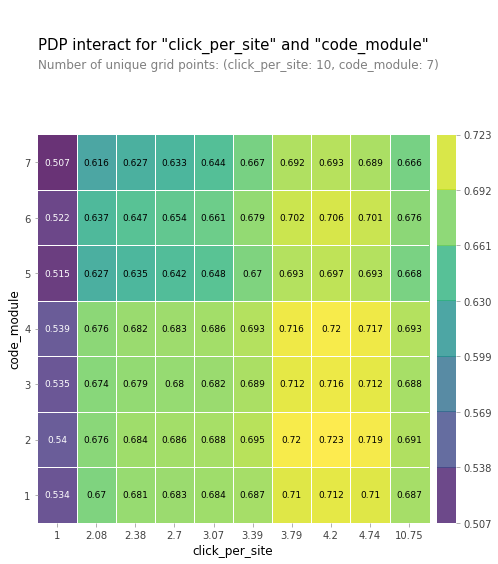

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=feature);

In [ ]:
row = X_val_df.iloc[[3160]]

In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row
)

In [ ]:
y_pred_proba = model.predict_proba(X_val_processed)

In [ ]:
y_pred_proba = y_pred_proba[:, 1]

In [ ]:
df_p = pd.DataFrame({
    'id_student': val_id, 
    'pred_proba': y_pred_proba,
    'status_group': y_val})

In [ ]:
len(y_val)

3590

In [ ]:
df_p.loc[df_p['id_student'] == 696318]

,id_student,pred_proba,status_group
20019,696318,0.933153,1


In [ ]:
df_pos = pd.merge(df_p, X_val_id, on = ['id_student'], how='left')

In [ ]:
df_pos.isnull().sum()

id_student                  0
pred_proba                  0
status_group                0
code_module                 0
code_presentation           0
date_registration           2
date_unregistration      3663
gender                      0
region                      0
highest_education           0
imd_band                  145
age_band                    0
num_of_prev_attempts        0
studied_credits             0
disability                  0
click_per_site             62
weighted_score_mean         0
late_rate                   0
fail_rate                   0
inter_date_per_length      62
dtype: int64

In [ ]:
Pass = df_pos['status_group'] == 1
Fail = ~Pass
right = (Pass) == (df_pos['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
df_pos[Pass & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id_student,pred_proba,status_group,code_module,code_presentation,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_per_site,weighted_score_mean,late_rate,fail_rate,inter_date_per_length
1869,2523350,0.825655,1,BBB,2014B,-41.0,NaN,F,West Midlands Region,HE Qualification,90-100%,35-55,0,60,N,2.383686,67.910000,0.700000,0.0,0.332029
2157,605832,0.842745,1,BBB,2013J,-21.0,NaN,F,East Midlands Region,A Level or Equivalent,0-10%,0-35,0,60,Y,2.783333,73.950000,0.454545,0.0,0.351866
2131,420631,0.851160,1,BBB,2014J,-66.0,NaN,F,Yorkshire Region,Lower Than A Level,50-60%,35-55,0,60,N,3.545198,74.700000,0.000000,0.2,0.315942
765,434562,0.857701,1,EEE,2013J,-150.0,NaN,M,South West Region,A Level or Equivalent,30-40%,35-55,0,60,N,3.266075,95.800000,0.000000,0.0,0.325144
3360,677491,0.858202,1,GGG,2014J,-46.0,NaN,M,Yorkshire Region,Lower Than A Level,0-10%,35-55,0,30,N,2.982379,72.000000,0.000000,0.0,0.409217
1491,384035,0.902252,1,GGG,2014B,-71.0,NaN,F,South East Region,A Level or Equivalent,40-50%,0-35,0,30,N,3.444898,75.666667,0.111111,0.0,0.403370
816,508637,0.905891,1,CCC,2014J,-81.0,NaN,M,Scotland,HE Qualification,20-30%,0-35,0,60,N,2.951304,91.975000,0.444444,0.0,0.408886
1725,601104,0.912444,1,FFF,2013J,-37.0,NaN,M,South Region,Lower Than A Level,90-100%,0-35,0,60,N,4.285185,72.750000,0.083333,0.0,0.378932
736,238007,0.914234,1,AAA,2013J,-151.0,NaN,M,South Region,HE Qualification,90-100%,55<=,0,60,N,2.604307,79.500000,0.000000,0.0,0.439821
2362,611329,0.938239,1,BBB,2014J,-37.0,NaN,F,London Region,HE Qualification,20-30%,0-35,0,60,N,4.519608,71.300000,0.000000,0.2,0.499018


In [ ]:
row_sample = X_val.loc[(X_val['code_module'] == 'BBB') & (X_val['date_registration'] == -37)]
row_sample

,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_per_site,late_rate,inter_date_per_length
5065,BBB,2014J,-37.0,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,1,120,Y,2.825503,0.000000,0.259081
3162,BBB,2013J,-37.0,F,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,2.604651,0.500000,0.398140
2262,BBB,2013J,-37.0,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,1,60,Y,1.691943,0.666667,0.347139
4815,BBB,2014J,-37.0,M,South East Region,Lower Than A Level,70-80%,0-35,0,60,Y,3.398551,0.000000,0.254398
5124,BBB,2014J,-37.0,F,London Region,HE Qualification,20-30%,0-35,0,60,N,4.519608,0.000000,0.499018


In [ ]:
row_sample.iloc[[4]]

,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_per_site,late_rate,inter_date_per_length
5124,BBB,2014J,-37.0,F,London Region,HE Qualification,20-30%,0-35,0,60,N,4.519608,0.0,0.499018


In [ ]:
row_sample = row_sample.iloc[[4]]

In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row_sample)
shap_values = explainer.shap_values(row_processed)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row_sample
)

In [ ]:
data_rows = X_val.iloc[:100]

In [ ]:
row_processed = processor.transform(data_rows)
shap_values = explainer.shap_values(row_processed)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=data_rows
)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(model,
                                 scoring='accuracy',
                                 n_iter=5,
                                 random_state=2)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_processed, y_val);

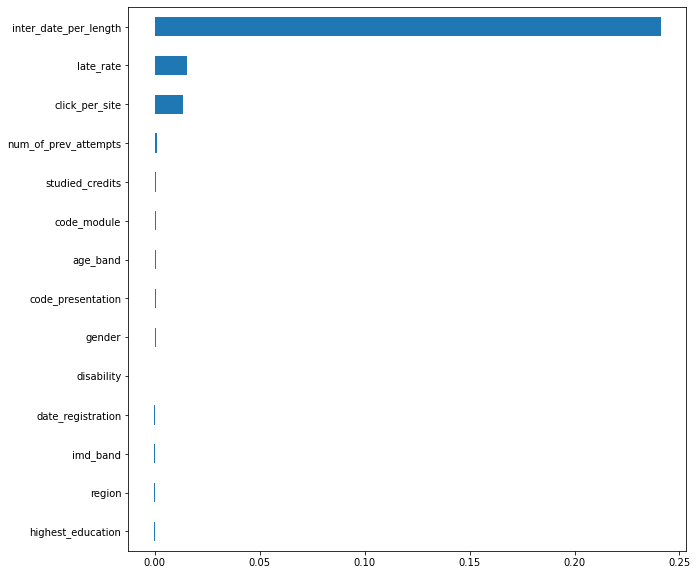

In [ ]:
plt.figure(figsize=(10, 10))

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values().plot.barh();

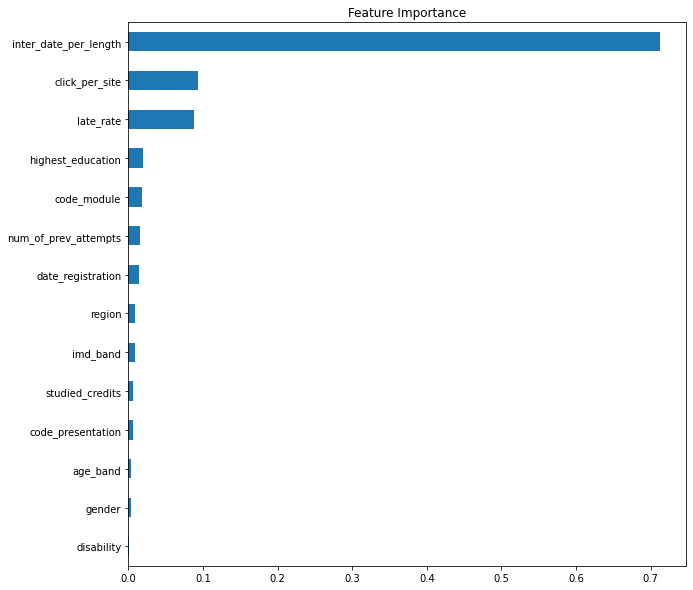

In [ ]:
importances = pd.Series(model.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title('Feature Importance')
importances.sort_values()[-n:].plot.barh();